In [1]:
%matplotlib inline
import pandas as pd

import matplotlib.pylab as plt

from IPython.display import display
import seaborn as sns
sns.set()

In [2]:
plans_changes = pd.read_csv('../data/Tariff_plans_change.csv')


In [3]:
plans_changes["END_DTTM"] = plans_changes["END_DTTM"]\
    .apply(lambda x: None if x == "$null$" else x)
for col in ("START_DTTM", "END_DTTM"):
    plans_changes[col] = pd.to_datetime(plans_changes[col])

plans_changes.head()


,SUBSCRIBER_ID,TARIFF_PLAN_ID,START_DTTM,END_DTTM
0,1,2,2013-11-22 21:10:08,2017-03-11 14:24:17
1,1,3,2017-03-11 14:24:18,NaT
2,2,1,2016-02-05 16:36:34,2017-06-29 12:39:58
3,2,5,2017-06-29 12:39:59,NaT
4,3,1,2015-05-06 19:17:46,2017-04-14 12:00:59


In [4]:
# предобработаем данныу в более удобный вид

from_plans = plans_changes[["SUBSCRIBER_ID",
                            "TARIFF_PLAN_ID", "END_DTTM"]].copy()
from_plans.rename(columns={"END_DTTM": "CHANGE_DTTM"}, inplace=True)
from_plans = from_plans[~from_plans["CHANGE_DTTM"].isnull()]

to_plans = plans_changes[["SUBSCRIBER_ID",
                          "TARIFF_PLAN_ID", "START_DTTM"]].copy()
to_plans["CHANGE_DTTM"] = to_plans["START_DTTM"] - pd.Timedelta(seconds=1)
to_plans.drop("START_DTTM", axis=1, inplace=True)

plans = from_plans.merge(
    to_plans, on=["SUBSCRIBER_ID", "CHANGE_DTTM"], suffixes=["_FROM", "_TO"])
plans["CHANGE_MONTH"] = plans["CHANGE_DTTM"].dt.to_period("M")
plans.drop("CHANGE_DTTM", axis=1, inplace=True)
plans.to_csv("tariff_changes.csv", index=False)
plans.head()


,SUBSCRIBER_ID,TARIFF_PLAN_ID_FROM,TARIFF_PLAN_ID_TO,CHANGE_MONTH
0,1,2,3,2017-03
1,2,1,5,2017-06
2,3,1,5,2017-04
3,4,3,5,2017-01
4,5,1,5,2017-05


In [5]:
# сгруппируем и посчитаем количества тарифных планов  которых перешли на которые
monthly_flows = plans.groupby(["CHANGE_MONTH", "TARIFF_PLAN_ID_FROM", "TARIFF_PLAN_ID_TO"])["SUBSCRIBER_ID"]\
    .agg(len).reset_index()
monthly_flows.rename(columns={"SUBSCRIBER_ID": "AMOUNT"}, inplace=True)

monthly_flows.head()


,CHANGE_MONTH,TARIFF_PLAN_ID_FROM,TARIFF_PLAN_ID_TO,AMOUNT
0,2017-01,1,3,23
1,2017-01,1,4,129
2,2017-01,1,5,212
3,2017-01,2,1,3
4,2017-01,2,3,3


Total number of plan changes per month:


,CHANGE_MONTH,AMOUNT
0,2017-01,1053
1,2017-02,1080
2,2017-03,1086
3,2017-04,1078
4,2017-05,1054
5,2017-06,1026


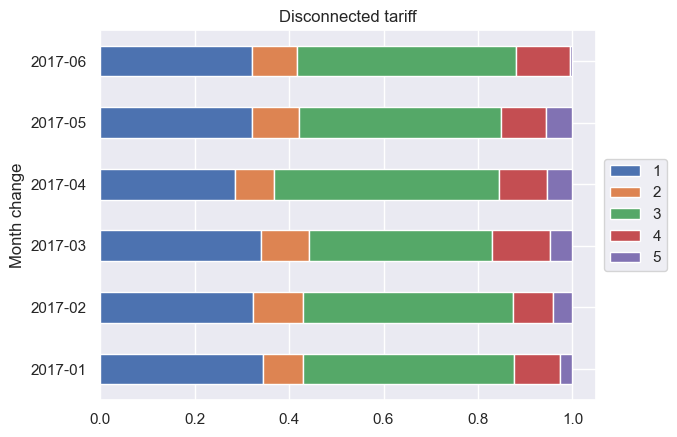

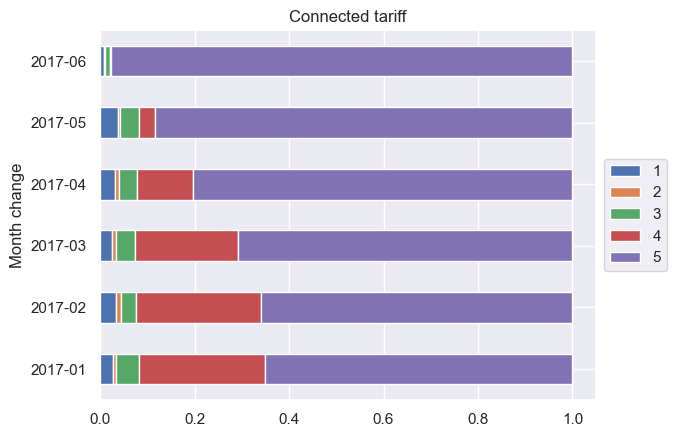

In [6]:
# вывод
def plot_tariff_flow(data, flow, percent=True):
    groupped = data.groupby(["CHANGE_MONTH", flow])["AMOUNT"]\
        .sum().reset_index()

    pvt = pd.pivot_table(data=groupped, columns=flow, index="CHANGE_MONTH",
                         values="AMOUNT", aggfunc=sum)
    if percent:
        pvt = pvt.div(pvt.sum(1), axis=0)

    pvt.plot(kind="barh", stacked=True)
    plt.xlabel("")
    plt.ylabel("Month change")
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.title({"TARIFF_PLAN_ID_FROM": "Disconnected tariff",
               "TARIFF_PLAN_ID_TO": "Connected tariff"}[flow])
    plt.show()


print("Total number of plan changes per month:")
display(monthly_flows.groupby("CHANGE_MONTH")["AMOUNT"].sum().reset_index())

plot_tariff_flow(monthly_flows, "TARIFF_PLAN_ID_FROM")
plot_tariff_flow(monthly_flows, "TARIFF_PLAN_ID_TO")


In [7]:
# функция для показа миграции с тарифных палнов 
def flows(data):
    pvt = pd.pivot_table(data=data, index="TARIFF_PLAN_ID_FROM", columns="TARIFF_PLAN_ID_TO",
                   values="AMOUNT", aggfunc=sum)\
        .fillna(0).astype(int)

    pvt["Total number from"]   = pvt.sum(1)
    pvt.loc["Total number per"] = pvt.sum(0)
    return pvt

print("Total change:")
flows(monthly_flows)

Total change:


TARIFF_PLAN_ID_TO,1,2,3,4,5,Total number from
TARIFF_PLAN_ID_FROM,,,,,,
1,0,5,55,378,1622,2060
2,13,0,20,156,415,604
3,30,12,0,379,2394,2815
4,37,20,57,0,537,651
5,96,4,94,53,0,247
Total number per,176,41,226,966,4968,6377


                        Conclusions:

The most popular rate plans for switching are 4 and 5. The most unpopular is 2.

Every month ~1,000 customers switch plans.